In [96]:
# Import all
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from scipy.stats import chi2_contingency

In [97]:
#Open the csv files
#This is the train file, it contains the 'Survived' column that will be our target
file_path = '/kaggle/input/titanic/train.csv'
df = pd.read_csv(file_path)

#This is the test dataset, it will be used at the end to create a prediction of the 'Survived' target
file_path = '/kaggle/input/titanic/test.csv'
df_test = pd.read_csv(file_path)

#Concatenate both dataframes to avoid doing the data cleaning both time.
df_all = pd.concat([df, df_test], sort=True).reset_index(drop=True)

## Data visualization

In [98]:
#Visualize the dataset
rows,columns = df_all.shape
str(rows) + " lines and " + str(columns) + " columns"

'1309 lines and 12 columns'

In [99]:
df_all.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [100]:
df_all.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


In [101]:
#Display the NaN
nanTotal = df_all.isnull().sum().sum()
print("\nThe dataset contains " + str(nanTotal) + " missing data for " + str(df_all.size) + ". Which is " + str(round(100*(nanTotal / (rows * columns)),2)) + " % of the total data\n")
print("Number of data missing per columns:")
colsWithNan = [col for col in df_all.columns if df_all[col].isnull().sum() > 0]
for col in colsWithNan:
    print(col + " : " + str(df_all[col].isnull().sum()) + " which is " + str(round(100*(df_all[col].isnull().sum()/rows),2)) + " % of the total of that column")


The dataset contains 1698 missing data for 15708. Which is 10.81 % of the total data

Number of data missing per columns:
Age : 263 which is 20.09 % of the total of that column
Cabin : 1014 which is 77.46 % of the total of that column
Embarked : 2 which is 0.15 % of the total of that column
Fare : 1 which is 0.08 % of the total of that column
Survived : 418 which is 31.93 % of the total of that column


We will have to infere the age for the 20% entries that are missing this value.

The cabin feature is an interesting value since it contain the information of the deck on which the passenger was. The deck is an indication to the distance to an exit. We will try to see if a correlation exists and if it is significatif we wil create a new feature.

The 2 entries with a missing 'Embarked' feature and the entry with a missing 'Fare' feature will just be droped.

The 418 missing 'Survived' are just the entries of the test dataframe.

## Data cleaning

In [102]:
#The name of the passenger isn't relevant
#The ticket number is not a fix format and shouldn't be relevant.
#We drop those columns
df_all.drop(['Name','Ticket'],axis=1,inplace=True)

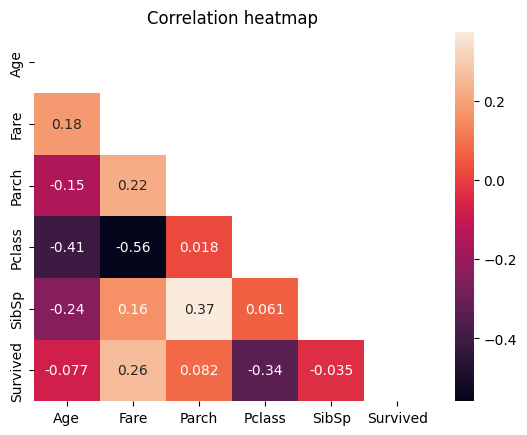

In [103]:
#We are checking the correlation heatmap of the data

#remove categorial columns and PassengerId
categorical_columns = df_all.select_dtypes(include=['object']).columns
df_temp = df_all.drop(categorical_columns, axis=1).drop('PassengerId', axis=1)

corr = df_temp.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

#plot the correlation heatmap
plt.title("Correlation heatmap")
sns.heatmap(corr,annot=True, mask=mask);
plt.show()

Here we can see a high inverse correlation between PClass and Survived. This would suggest that a higher proportion of 1st class passenger have survived.

Fare and Pclass are highly correlated too as we could expect. But Fare is also slightly correlated with the number of family member (Parch and SibSp)

Fare is also correlated with Survived which can be a result of a higher Pclass ticket price.

PClass is correlated to age, an older passenger has more chance to be in lower passenger class.

SibSp and ParCh are correlated which show that some passenger travel as part of a family.

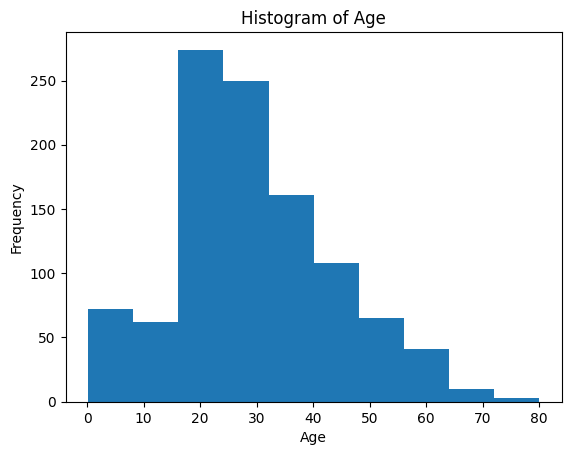

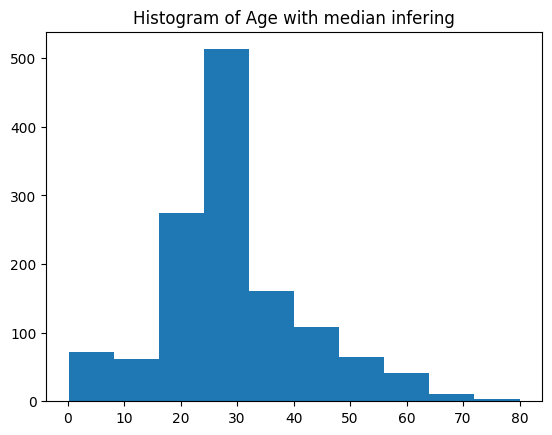

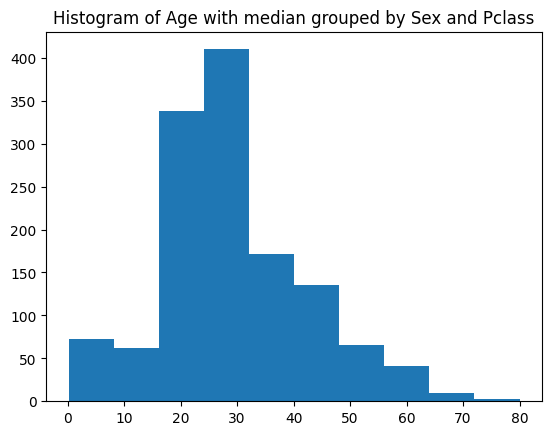

In [104]:
#We want to see the age distribution to check if we could infere the missing values
#1: We replace the missing values by the median of the Age column.
#2: We replace the missing values by the median of the age grouped by sex and pclass
median = df_all['Age'].median()
df_temp1 = df_all['Age'].fillna(median)

df_temp2 = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

min_value = df_all['Age'].min()
max_value = df_all['Age'].max()

plt.xlabel('Age')
plt.ylabel('Frequency')

plt.title('Histogram of Age')
plt.hist(df_all['Age'],range=(min_value, max_value),alpha=1)
plt.show()

plt.title('Histogram of Age with median infering')
plt.hist(df_temp1,range=(min_value, max_value),alpha=1)
plt.show()

plt.title('Histogram of Age with median grouped by Sex and Pclass')
plt.hist(df_temp2,range=(min_value, max_value),alpha=1)
plt.show()



In [105]:
#The distribution is better with class and sex infering. We fill the age related NAN with those values
#separating the dataframe before to avoid feature leakage
df = df_all[df_all['Survived'].notna()]
df_test = df_all[df_all['Survived'].isna()]

df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
df_test['Age'] = df_test.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

df_all = pd.concat([df, df_test], sort=True).reset_index(drop=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [106]:
#Only two lines of the dataset don't have informations about the embarking port. We drop those lines
df_all.dropna(subset=['Embarked'], inplace=True)

#Only one line of the dataset doesn't have information about the fare. We drop this line
df_all.dropna(subset=['Fare'], inplace=True)

## Feature engineering

In [107]:
#Creating a 'Deck' feature and checking if a correlation with 'Survived' exists
df_temp = df_all
df_temp['Deck'] = df_temp['Cabin'].apply(lambda x: x[0] if pd.notnull(x) and x != '' else 'Missing')

table = pd.crosstab(df_temp['Deck'], df_temp['Survived'])
chi2, p, dof, expected = chi2_contingency(table)
print(f"Chi-Square value = {chi2}")
print(f"P-value = {p}")

Chi-Square value = 96.65456540501457
P-value = 2.0576925539801955e-17


We see a very small p-value which indicates that the new feature 'Deck' is not independant from 'Survived'.

In [108]:
#Adding 'Deck' and dropping 'Cabin'
df_all = df_temp.drop(['Cabin'],axis=1)

In [109]:
#We will create a feature for family size as it might be more interesting than the parent/children and Sibling/spouse numbers
df_temp = df_all
df_temp['FamSize'] = df_temp['SibSp']+df_temp['Parch']

df_all = df_temp

In [110]:
#We split the df_all dataframe into train and test dataframes again
df = df_all[df_all['Survived'].notna()]
df_test = df_all[df_all['Survived'].isna()]

In [111]:
#We split the train dataframe into target and features and drop the passengerId feature
df.drop('PassengerId',axis=1,inplace=True)
X = df.drop('Survived', axis=1)
y = df['Survived']


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [112]:
#Encoding of categorical variable
#Sex,Embarked and Deck are categorical data. We encode them.
X_encoded = pd.get_dummies(X)


## Model training

In [113]:
# Separate into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y, test_size=0.2, random_state=1)


In [114]:
#Create the random forest model and fit the data

#Create the hyperparameter grid for the GridSearchCV
clf = RandomForestClassifier()

param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [4,6,8],
    'min_samples_split': [2,4,6],
    'min_samples_leaf': [1,2,4]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=1, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_predic = best_model.predict(X_valid)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 50}


In [115]:
#Predict and calculate the accuracy
y_predic = best_model.predict(X_valid)

#Calculate the accuracy
clf_accuracy = accuracy_score(y_predic, y_valid)
print(clf_accuracy.round(4))

0.8315


We got an accuracy of 83.15% on predicting passengers surviving rate.

The baseline accuracy for a model that always predict the majority output (death) is 61.7% (number of passengers that did not survive / number of passengers)

So this model is significantly better at predicting survival rate .

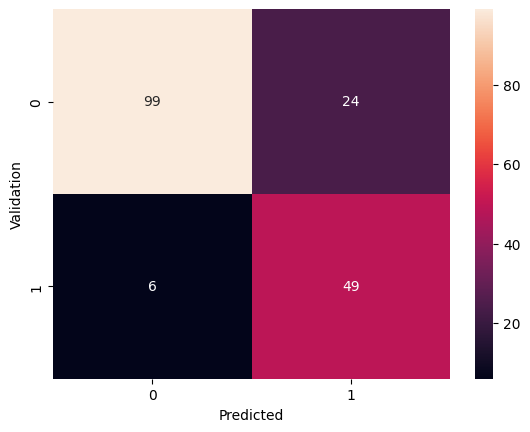

In [116]:
#Plot a confusion matrix
cm = confusion_matrix(y_predic, y_valid)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Validation')
plt.show()

In [117]:
#Compute the precision and sensitivity
tn, fp, fn, tp = cm.ravel()

print("sensitivity: " + str((tn/(tn+fn)).round(4)))
print("precision: " + str(precision_score(y_predic, y_valid).round(4)))

sensitivity: 0.9429
precision: 0.6712


We can see that the model is able to predict quite well when a passenger hasn't been able to survive. The sensitivity is 94.294%

But it struggles a bit more to predict when a passenger was able to survive. The precision is 67.12% 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


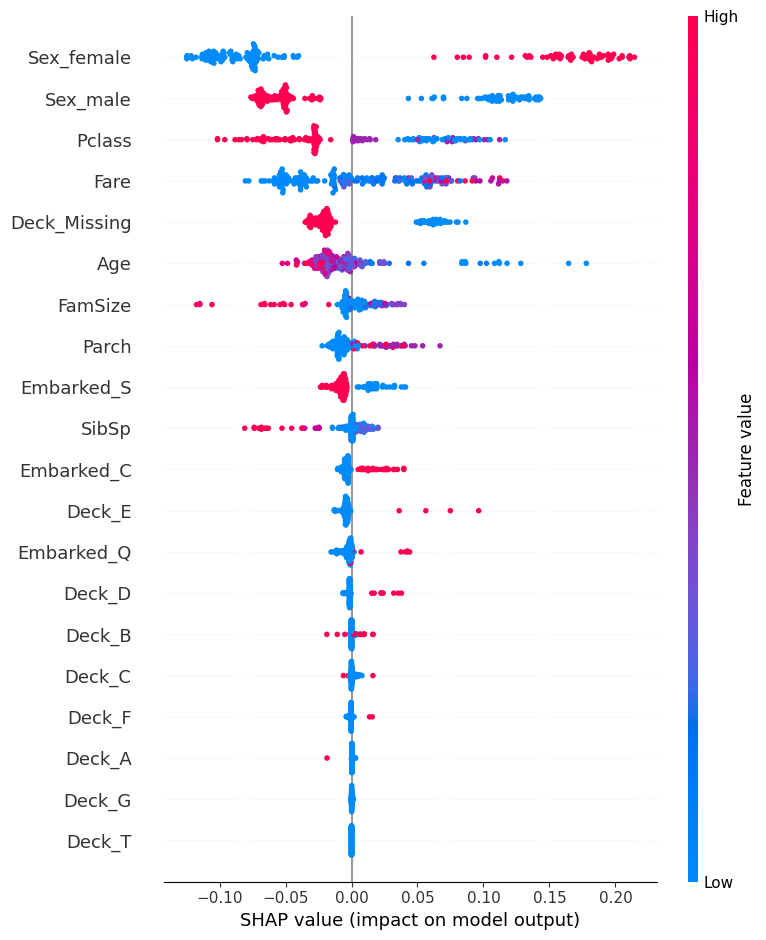

In [118]:
#Exploring the Shap values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values[1], X_valid)

The biggest factor of survival is the sex of the passenger. Female have a higher chance of suriving than male.

Passengers in class 1 and 2 have a higher chance to survive as we expected.

The effect is less visible, but we can see that the highest fare has a positive effect on the chance of survival

A missing deck his somewhat linked with a lower chance of survival, this can be explained by the fact that passenger with missing Cabin number were in majority class 2 and 3. Some decks have a higher survival chance, like E, B, D and F.

Child passengers have a better chance to survive.

The effect of family size isn't clear, but we can see that highest and lowest family size do have a lesser chance of survival.

Embarking in Shouthampton and Queesntown is mildly linked to a higher chance of not surviving. Passenger from Cherbourg have a higher chance to survive.

Having more parents or children slightly improve the odds of survival

Having a lot or siblings/spouse slightly decrease the chances of survival.